<a href="https://colab.research.google.com/github/andysun-1997/VQE-Sample-Problem-with-Cirq-and-TensorFlow-Quantum/blob/master/VQE_Sample_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.1.0

In [0]:
!pip install tensorflow-quantum

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [0]:
symbols = sympy.symbols('a b c d e f g h i')

In [0]:
q0, q1, q2 = cirq.GridQubit.rect(1, 3)

In [0]:
def get_var_form(symbols):
  circuit = cirq.Circuit(
    cirq.rx(symbols[0]).on(q0),
    cirq.rx(symbols[1]).on(q1), 
    cirq.rx(symbols[2]).on(q2), cirq.CNOT(control=q0, target=q1), cirq.CNOT(control=q1, target=q2), 
    cirq.ry(symbols[3]).on(q0), cirq.ry(symbols[4]).on(q1), cirq.ry(symbols[5]).on(q2),
    cirq.CNOT(control=q2, target=q1), cirq.CNOT(control=q1, target=q0),
    cirq.rz(symbols[6]).on(q0), cirq.rz(symbols[7]).on(q1), cirq.rz(symbols[8]).on(q2))
  return circuit

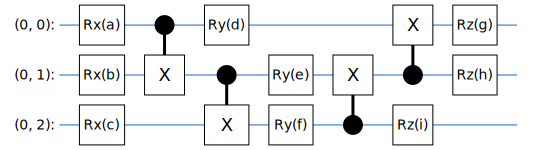

In [48]:
# Circuit Visualization
circuit = get_var_form(symbols)
SVGCircuit(circuit)

In [49]:
# Operator H
ops = [cirq.PauliString([cirq.X(q0), cirq.X(q2)]) + 0.9*cirq.Z(q0) - 0.3*cirq.Y(q2)] 
ops

[cirq.PauliSum(cirq.LinearDict({frozenset({(cirq.GridQubit(0, 0), cirq.X), (cirq.GridQubit(0, 2), cirq.X)}): (1+0j), frozenset({(cirq.GridQubit(0, 0), cirq.Z)}): (0.9+0j), frozenset({(cirq.GridQubit(0, 2), cirq.Y)}): (-0.3+0j)}))]

In [0]:
def energy(params):
  values = [params]
  qc = get_var_form(symbols)
  expectation_layer = tfq.layers.Expectation()
  output = expectation_layer( 
    qc, 
    symbol_names=symbols,
    symbol_values=values, 
    operators=ops, 
    # initializer=tf.keras.initializers.RandomUniform(0, 2 * np.pi)
  )
  return float(output)

In [0]:
from scipy.optimize import minimize
from scipy import optimize
import random

params = [random.uniform(0, 2 * np.pi) for i in range(9)]
b = (0, 2 * np.pi)
bnds = [b,b,b,b,b,b,b,b,b]
res = minimize(energy, params, method='Nelder-Mead', tol=0.001) # COBYLA ## Nelder-Mead # powell
# res = minimize(energy, params, method='SLSQP', bounds=bnds, tol=0.001)

# global optimization
# res = optimize.dual_annealing(energy, bnds) # shgo ## dual_annealing (slow) # differential_evolution (very slow)

In [63]:
print(res)

 final_simplex: (array([[ 7.20409209e-01,  1.56865475e+00,  6.52863060e+00,
         6.28347965e+00,  3.46296941e+00,  7.96294289e-04,
         4.71289311e+00,  3.61815672e+00, -9.74715174e-04],
       [ 7.20473142e-01,  1.56849941e+00,  6.52858155e+00,
         6.28319601e+00,  3.46315127e+00,  7.85413043e-04,
         4.71254016e+00,  3.61813930e+00, -1.11402066e-03],
       [ 7.20357680e-01,  1.56868447e+00,  6.52865822e+00,
         6.28323472e+00,  3.46291865e+00,  4.48133000e-04,
         4.71238140e+00,  3.61771566e+00, -1.05089433e-03],
       [ 7.20662505e-01,  1.56850283e+00,  6.52868590e+00,
         6.28339923e+00,  3.46327124e+00,  5.28495586e-04,
         4.71279601e+00,  3.61858922e+00, -1.18829446e-03],
       [ 7.20420886e-01,  1.56902767e+00,  6.52856418e+00,
         6.28343043e+00,  3.46282452e+00,  5.82837202e-04,
         4.71264551e+00,  3.61772055e+00, -1.26747386e-03],
       [ 7.20516649e-01,  1.56865816e+00,  6.52862424e+00,
         6.28345396e+00,  3.463143

In [64]:
# Benchmark: Difference between exact and estimated eigenvalues
abs(res.fun - (-1.5620499351813313))

1.0231329914400789e-06

In [65]:
# Estimated eigenstate
resolver = cirq.ParamResolver({symbols[0]: res.x[0], symbols[1]: res.x[1], symbols[2]: res.x[2], 
                               symbols[3]: res.x[3], symbols[4]: res.x[4], symbols[5]: res.x[5],
                               symbols[6]: res.x[6], symbols[7]: res.x[7], symbols[8]: res.x[8]})
qc = get_var_form(symbols)
output_state = cirq.Simulator().simulate(qc, resolver).final_state
output_state

array([ 0.01340457-0.02148858j, -0.02141912-0.01271717j,
       -0.20409162+0.12422292j,  0.12484835+0.204563j  ,
        0.05953079+0.03621145j, -0.03633054+0.05949059j,
       -0.3439627 -0.5655872j ,  0.5640402 -0.34375206j], dtype=complex64)